In [2]:
import torch
import torchaudio
from dataclasses import dataclass
import matplotlib.pyplot as plt

torch.random.manual_seed(0)

from pydub import AudioSegment

print(torch.__version__)
print(torchaudio.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.2.2
2.2.2
cpu


In [3]:
transcript_original = "|अब्राहम|की|सन्तान|दाऊद|की|सन्तान|यीशु|मसीह|की|वंशावली|अब्राहम|से|इसहाक|उत्पन्न|हुआ|"
SPEECH_FILE = "/Users/Nishant/Desktop/sarvam/10s_sample.mp3" # 10 second sample taken from the original audio, first audio file

In [4]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCTC, AutoProcessor
import torchaudio.functional as F

DEVICE_ID = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "ai4bharat/indicwav2vec-hindi"

model = AutoModelForCTC.from_pretrained(MODEL_ID).to(DEVICE_ID)
processor = AutoProcessor.from_pretrained(MODEL_ID)

/Users/Nishant/miniconda3/envs/sarvam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at ai4bharat/indicwav2vec-hindi were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initializ

In [5]:
from datasets import load_dataset, Audio, Dataset

audio_dataset = Dataset.from_dict(
    {
        "audio": [
            SPEECH_FILE,
        ]
    }
).cast_column("audio", Audio())
audio_dataset[0]["audio"]

{'path': '/Users/Nishant/Desktop/sarvam/10s_sample.mp3',
 'array': array([ 0.        ,  0.        ,  0.        , ..., -0.04459506,
        -0.03979012, -0.03902366]),
 'sampling_rate': 24000}

In [57]:
sample = audio_dataset[0]
resampled_audio = F.resample(
    torch.tensor(sample["audio"]["array"]), 48000, 16000
).numpy()

input_values = processor(resampled_audio, return_tensors="pt").input_values

Some weights of the model checkpoint at ai4bharat/indicwav2vec-hindi were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at ai4bharat/indicwav2vec-hindi and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this mode

In [58]:
with torch.no_grad():
    logits = model(input_values.to(DEVICE_ID)).logits.cpu()

# logits = logits.squeeze()
prediction_ids = torch.argmax(logits, dim=-1)
print(prediction_ids.shape)
print(logits.shape)

torch.Size([1, 247])
torch.Size([1, 247, 68])


In [9]:
emission = logits.squeeze()
emission.shape

torch.Size([499, 68])

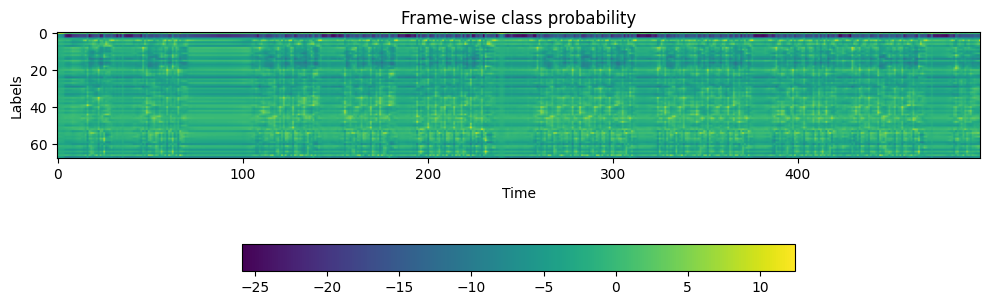

In [59]:
def plot():
    fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [60]:
labels = tuple(processor.tokenizer.get_vocab().keys())
labels

('<s>',
 '<pad>',
 '</s>',
 '<unk>',
 '|',
 'ँ',
 'ं',
 'ः',
 'अ',
 'आ',
 'इ',
 'ई',
 'उ',
 'ऊ',
 'ऋ',
 'ए',
 'ऐ',
 'ऑ',
 'ओ',
 'औ',
 'क',
 'ख',
 'ग',
 'घ',
 'ङ',
 'च',
 'छ',
 'ज',
 'झ',
 'ञ',
 'ट',
 'ठ',
 'ड',
 'ढ',
 'ण',
 'त',
 'थ',
 'द',
 'ध',
 'न',
 'प',
 'फ',
 'ब',
 'भ',
 'म',
 'य',
 'र',
 'ल',
 'व',
 'श',
 'ष',
 'स',
 'ह',
 '़',
 'ा',
 'ि',
 'ी',
 'ु',
 'ू',
 'ृ',
 'ॅ',
 'े',
 'ै',
 'ॉ',
 'ो',
 'ौ',
 '्',
 'ळ')

In [61]:
transcript = transcript_original
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

[('|', 4), ('अ', 8), ('ब', 42), ('्', 66), ('र', 46), ('ा', 54), ('ह', 52), ('म', 44), ('|', 4), ('क', 20), ('ी', 56), ('|', 4), ('स', 51), ('न', 39), ('्', 66), ('त', 35), ('ा', 54), ('न', 39), ('|', 4), ('द', 37), ('ा', 54), ('ऊ', 13), ('द', 37), ('|', 4), ('क', 20), ('ी', 56), ('|', 4), ('स', 51), ('न', 39), ('्', 66), ('त', 35), ('ा', 54), ('न', 39), ('|', 4), ('य', 45), ('ी', 56), ('श', 49), ('ु', 57), ('|', 4), ('म', 44), ('स', 51), ('ी', 56), ('ह', 52), ('|', 4), ('क', 20), ('ी', 56), ('|', 4), ('व', 48), ('ं', 6), ('श', 49), ('ा', 54), ('व', 48), ('ल', 47), ('ी', 56), ('|', 4), ('अ', 8), ('ब', 42), ('्', 66), ('र', 46), ('ा', 54), ('ह', 52), ('म', 44), ('|', 4), ('स', 51), ('े', 61), ('|', 4), ('इ', 10), ('स', 51), ('ह', 52), ('ा', 54), ('क', 20), ('|', 4), ('उ', 12), ('त', 35), ('्', 66), ('प', 40), ('न', 39), ('्', 66), ('न', 39), ('|', 4), ('ह', 52), ('ु', 57), ('आ', 9), ('|', 4)]


In [62]:
def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0) # 169
    num_tokens = len(tokens) # number of characters in transcript

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

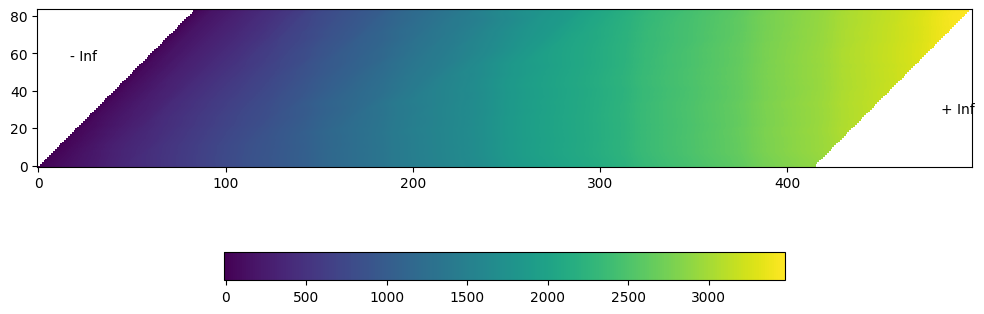

In [63]:
def plot():
    fig, ax = plt.subplots(figsize=(10, 6))
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [64]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=0, score=88078.640625)
Point(token_index=0, time_index=1, score=87736.4296875)
Point(token_index=0, time_index=2, score=49059.48828125)
Point(token_index=0, time_index=3, score=25315.53515625)
Point(token_index=0, time_index=4, score=15082.8857421875)
Point(token_index=0, time_index=5, score=10417.43359375)
Point(token_index=0, time_index=6, score=7478.86279296875)
Point(token_index=0, time_index=7, score=3756.77294921875)
Point(token_index=0, time_index=8, score=2392.92333984375)
Point(token_index=0, time_index=9, score=2406.06982421875)
Point(token_index=0, time_index=10, score=2326.624755859375)
Point(token_index=0, time_index=11, score=2091.0947265625)
Point(token_index=0, time_index=12, score=1569.281494140625)
Point(token_index=0, time_index=13, score=1231.8101806640625)
Point(token_index=0, time_index=14, score=2263.0908203125)
Point(token_index=0, time_index=15, score=6217.96533203125)
Point(token_index=0, time_index=16, score=23.5690860748291)
P

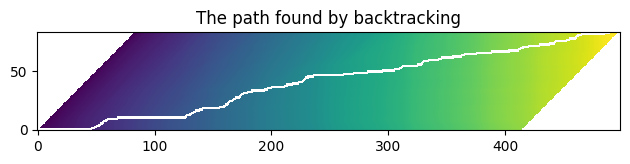

In [65]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

In [66]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

|	(11838.56): [    0,    47)
अ	(1351.57): [   47,    49)
ब	(4618.62): [   49,    51)
्	(484.21): [   51,    53)
र	(165.05): [   53,    54)
ा	(262.66): [   54,    56)
ह	(0.73): [   56,    57)
म	(908.03): [   57,    59)
|	(2176.87): [   59,    60)
क	(4200.50): [   60,    69)
ी	(1904.36): [   69,   127)
|	(1548.34): [  127,   128)
स	(5559.66): [  128,   131)
न	(332.50): [  131,   132)
्	(1552.79): [  132,   134)
त	(2517.40): [  134,   136)
ा	(3789.06): [  136,   139)
न	(2085.07): [  139,   142)
|	(14403.04): [  142,   156)
द	(674.69): [  156,   160)
ा	(0.18): [  160,   161)
ऊ	(1468.31): [  161,   163)
द	(143.49): [  163,   164)
|	(20.46): [  164,   165)
क	(1285.28): [  165,   167)
ी	(1312.53): [  167,   168)
|	(1407.25): [  168,   170)
स	(2327.36): [  170,   173)
न	(315.13): [  173,   174)
्	(155.28): [  174,   175)
त	(4079.64): [  175,   177)
ा	(2926.64): [  177,   180)
न	(5290.14): [  180,   184)
|	(15473.70): [  184,   195)
य	(5988.67): [  195,   197)
ी	(1612.38): [  197,   201)
श	(121

/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_49621/3139461363.py:38: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_49621/3139461363.py:38: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_49621/3139461363.py:38: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_49621/3139461363.py:38: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_49621/3139461363.py:38: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_49621/31

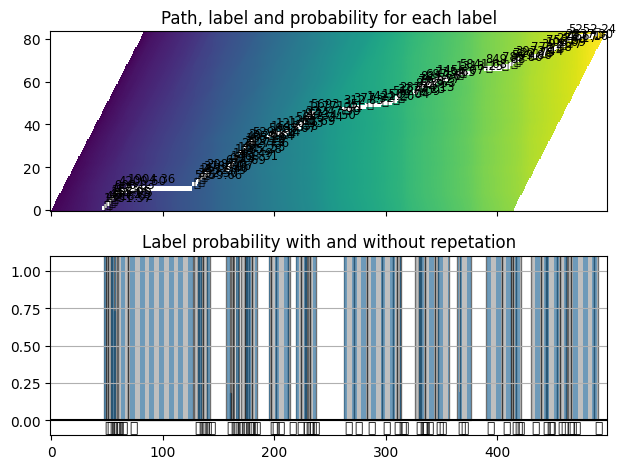

In [67]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

In [68]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(
                    seg.length for seg in segs
                )
                words.append(
                    Segment(word, segments[i1].start, segments[i2 - 1].end, score)
                )
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

अब्राहम	(1284.67): [   47,    59)
की	(2212.80): [   60,   127)
सन्तान	(3055.30): [  128,   142)
दाऊद	(722.38): [  156,   164)
की	(1294.37): [  165,   168)
सन्तान	(3253.73): [  170,   184)
यीशु	(1807.18): [  195,   214)
मसीह	(8568.68): [  219,   229)
की	(7429.94): [  230,   237)
वंशावली	(1945.02): [  262,   313)
अब्राहम	(960.88): [  326,   356)
से	(4796.66): [  363,   376)
इसहाक	(1298.20): [  389,   421)
उत्पन्न	(1127.88): [  430,   462)
हुआ	(10855.95): [  463,   490)


In [69]:
waveform = torch.tensor(resampled_audio).unsqueeze(dim = 0)
sample_rate = 16000

/Users/Nishant/miniconda3/envs/sarvam/lib/python3.10/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_49621/3784634883.py:46: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_49621/3784634883.py:46: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_49621/3784634883.py:46: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_49621/3784634883.py:46: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_49621/3784634883.py:

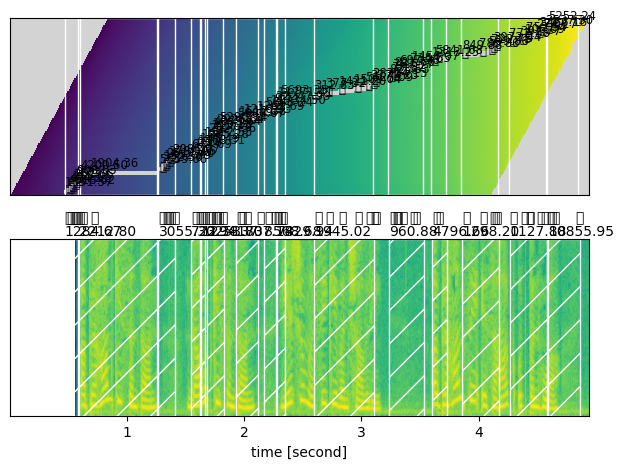

In [70]:
def plot_alignments(
    trellis, segments, word_segments, waveform, sample_rate=16_000
):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(
            word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none"
        )

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = waveform.size(0) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(
            f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False
        )

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(
                seg.label,
                (seg.start * ratio, sample_rate * 0.55),
                annotation_clip=False,
            )
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)

In [71]:
import IPython

def display_segment(i):
    ratio = waveform.size(1) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(x0, x1)
    print(
        f"{word.label} ({word.score:.2f}): {x0 / 16_000:.3f} - {x1 / 16_000:.3f} sec"
    )
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=16_000)

In [72]:
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(SPEECH_FILE)

|अब्राहम|की|सन्तान|दाऊद|की|सन्तान|यीशु|मसीह|की|वंशावली|अब्राहम|से|इसहाक|उत्पन्न|हुआ|


In [73]:
for i in range(len(word_segments)):
    display_segment(i)
    

7459 9364
अब्राहम (1284.67): 0.466 - 0.585 sec
9523 20157
की (2212.80): 0.595 - 1.260 sec
20315 22537
सन्तान (3055.30): 1.270 - 1.409 sec
24759 26029
दाऊद (722.38): 1.547 - 1.627 sec
26188 26664
की (1294.37): 1.637 - 1.667 sec
26981 29204
सन्तान (3253.73): 1.686 - 1.825 sec
30949 33965
यीशु (1807.18): 1.934 - 2.123 sec
34759 36346
मसीह (8568.68): 2.172 - 2.272 sec
36505 37616
की (7429.94): 2.282 - 2.351 sec
41583 49678
वंशावली (1945.02): 2.599 - 3.105 sec
51741 56503
अब्राहम (960.88): 3.234 - 3.531 sec
57614 59677
से (4796.66): 3.601 - 3.730 sec
61741 66820
इसहाक (1298.20): 3.859 - 4.176 sec
68248 73327
उत्पन्न (1127.88): 4.266 - 4.583 sec
73486 77771
हुआ (10855.95): 4.593 - 4.861 sec


In [78]:
display_segment(4)

26188 26664
की (1294.37): 1.637 - 1.667 sec


In [52]:
sound_file = AudioSegment.from_mp3(SPEECH_FILE)
sound_file = sound_file[3100:13000]

display(sound_file)

In [53]:
sound_file.export("10s_sample.mp3",format= "mp3")

<_io.BufferedRandom name='10s_sample.mp3'>